<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynamiccompressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! apt update -q
! apt-get install -q openjdk-25-jdk-headless -q
!pip install neqsim

Relevant info:
[Intro to dynamic process simulations in neqsim](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynamicsimul.ipynb)

#Dynamic compressor calculations using NeqSim

In the following examples we look into how dynamic calculations in NeqSim can be used for compression processes. We will further demonstrate how to controll the process and how to implement an anti surge controll algorithm.



#Example 1: Process behavior when increasing speed of the compressor.
In this exampe we would expect that the flow through the compressor will increase, and that the pressure of the inlet separator will drop, whil the pressure of the outlet process will increase. The pressure change will be dependent on the volume of gas upstream and downstream the compressor.

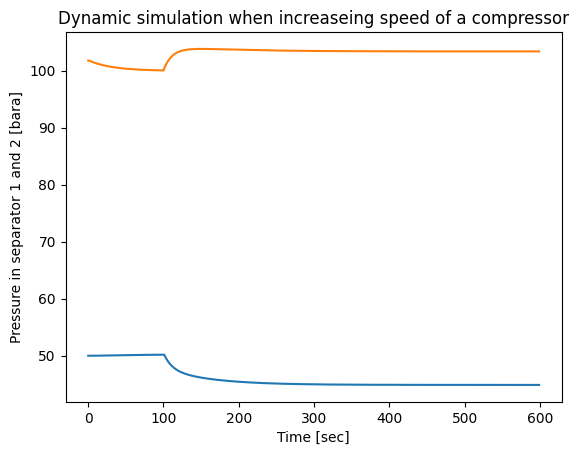

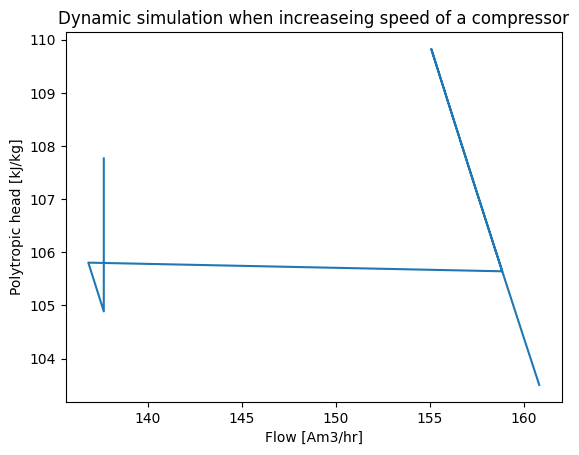

In [2]:
import neqsim
from neqsim import jneqsim

import matplotlib.pyplot as plt

testSystem2 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
testSystem2.addComponent("methane", 1.1);
testSystem2.addComponent("ethane", 0.1);
testSystem2.setMixingRule(2);

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", testSystem2);
stream1.setFlowRate(5000.0, "kg/hr");
stream1.setPressure(100.0, "bara");
stream1.setTemperature(55.0, "C");

valve1 = jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(50.0);
valve1.setPercentValveOpening(50);
valve1.setCalculateSteadyState(False);

separator1 = jneqsim.process.equipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream());
separator1.setCalculateSteadyState(False);
separator1.setSeparatorLength(3.0);
separator1.setInternalDiameter(0.8);
separator1.setLiquidLevel(0.0);

compressor1 = jneqsim.process.equipment.compressor.Compressor('comp1', separator1.getGasOutStream());
compressor1.setCalculateSteadyState(False);
compressor1.setOutletPressure(100.0);

separator2 = jneqsim.process.equipment.separator.Separator("separator_2");
separator2.addStream(compressor1.getOutletStream());
separator2.setCalculateSteadyState(False);
separator2.setSeparatorLength(3.0);
separator2.setInternalDiameter(0.8);
separator2.setLiquidLevel(0.0);

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", separator2.getGasOutStream());
valve2.setOutletPressure(50.0);
valve2.setPercentValveOpening(50);
valve2.setCalculateSteadyState(False);

p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(separator1);
p.add(compressor1);
p.add(separator2);
p.add(valve2);

p.run();
compchartgenerator = jneqsim.process.equipment.compressor.CompressorChartGenerator(compressor1);
compressor1.setCompressorChart(compchartgenerator.generateCompressorChart("normal"));
compressor1.getCompressorChart().setUseCompressorChart(True);
p.run();


time = []
pressuresep1 = []
pressuresep2= []
flow = []
head = []

p.setTimeStep(1.0);
for i in range(100):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  p.runTransient();

#increaseing compressor speed
compressor1.setSpeed(compressor1.getSpeed()+200)
for i in range(500):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()


Text(0, 0.5, 'Head [kJ/kg]')

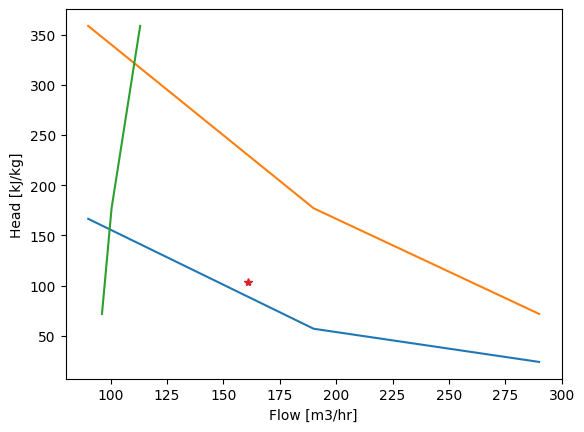

In [3]:
flow = []
head = []
head2 = []
surge =[]

for i in range(90,300,100):
    flow.append(i)
    head.append(compressor1.getCompressorChart().getPolytropicHead(i, 3000))
    head2.append(compressor1.getCompressorChart().getPolytropicHead(i, 4000))

for i in head:
  surge.append(compressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(i))

plt.plot(flow, head)
plt.plot(flow, head2)
plt.plot(surge, head2)
plt.plot(compressor1.getInStream().getFlowRate('m3/hr'), compressor1.getPolytropicFluidHead(), marker='*')
plt.xlabel('Flow [m3/hr]')
plt.ylabel('Head [kJ/kg]')

#Example 2: Process behavior when adding compressor speed controll
In this exampe we will add a compressor speed controller for controlling pressure downstream the compressor. A PI regulator will be used for controlling the speed. We start with a process with 100 bara output pressure and increase the setpoint of the controller to 120 bara.

 speed  3000.0 feed flow  501.0  compressor flow rate  501.0  out flow  501.0  delta p  51.74353604996071  pres inn  50.0  pres out  101.74353604996071


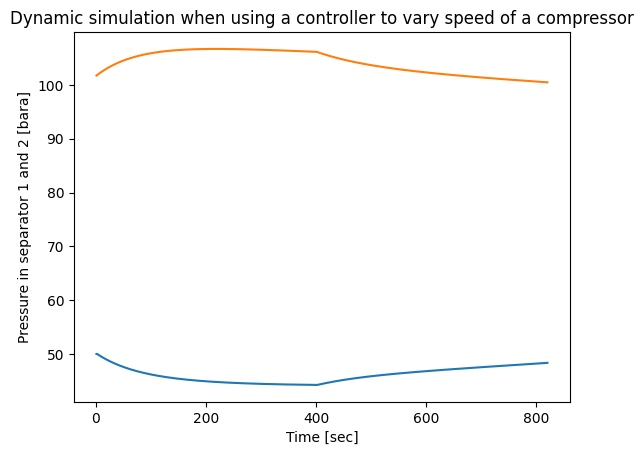

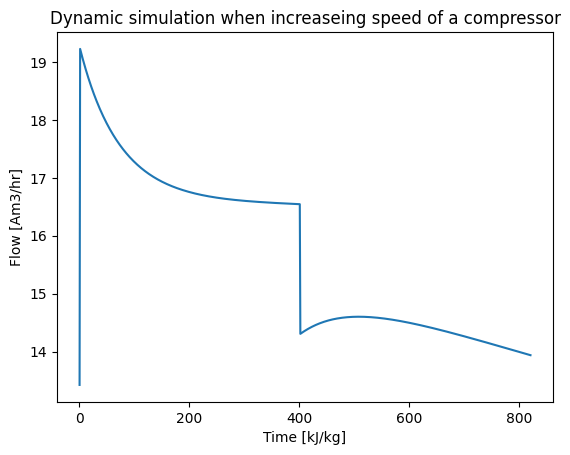

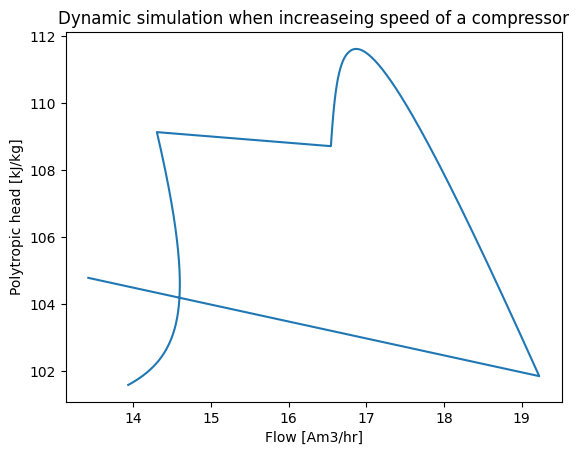

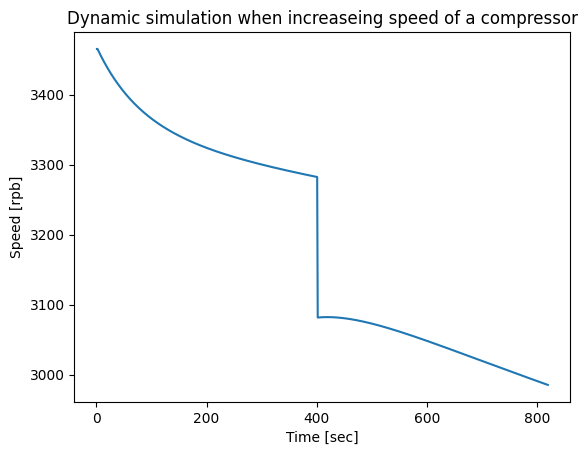

In [4]:
testSystem2 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
testSystem2.addComponent("methane", 1.1);
testSystem2.addComponent("ethane", 0.1);
testSystem2.setMixingRule(2);

stream1 =  jneqsim.process.equipment.stream.Stream("Stream1", testSystem2);
stream1.setFlowRate(501.0, "kg/hr");
stream1.setPressure(100.0, "bara");
stream1.setTemperature(55.0, "C");

valve1 = jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(50.0);
valve1.setPercentValveOpening(10);
valve1.setCalculateSteadyState(False);

separator1 = jneqsim.process.equipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream());
separator1.setCalculateSteadyState(False);
separator1.setSeparatorLength(3.0);
separator1.setInternalDiameter(0.8);
separator1.setLiquidLevel(0.0);

compressor1 = jneqsim.process.equipment.compressor.Compressor('comp1', separator1.getGasOutStream());
compressor1.setCalculateSteadyState(False);
compressor1.setOutletPressure(100.0);

separator2 = jneqsim.process.equipment.separator.Separator("separator_2");
separator2.addStream(compressor1.getOutletStream());
separator2.setCalculateSteadyState(False);
separator2.setSeparatorLength(3.0);
separator2.setInternalDiameter(0.8);
separator2.setLiquidLevel(0.0);

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", separator2.getGasOutStream());
valve2.setOutletPressure(50.0);
valve2.setPercentValveOpening(50);
valve2.setCalculateSteadyState(False);

separatorPressureTransmitter = jneqsim.process.measurementdevice.PressureTransmitter(separator2.getGasOutStream());

speedController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass();
speedController.setReverseActing(True);
speedController.setTransmitter(separatorPressureTransmitter);
speedController.setControllerSetPoint(100.0);
speedController.setControllerParameters(0.2, 500.0, 0.0);

p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(separator1);
p.add(compressor1);
p.add(separator2);
p.add(separatorPressureTransmitter);
p.add(valve2);
compressor1.setController(speedController);



p.run();
compchartgenerator = jneqsim.process.equipment.compressor.CompressorChartGenerator(compressor1);
compressor1.setCompressorChart(compchartgenerator.generateCompressorChart("normal"));
compressor1.getCompressorChart().setUseCompressorChart(True);
p.run();

print(" speed " , compressor1.getSpeed() , "feed flow "
, stream1.getFlowRate("kg/hr") , " compressor flow rate "
, compressor1.getInletStream().getFlowRate("kg/hr") , " out flow "
, valve2.getOutletStream().getFlowRate("kg/hr") , " delta p "
, (compressor1.getOutletStream().getPressure() - compressor1.getInletStream().getPressure())
, " pres inn " , compressor1.getInletStream().getPressure() , " pres out "
, compressor1.getOutletStream().getPressure());

p.setTimeStep(1.0);
p.runTransient();

time = []
pressuresep1 = []
pressuresep2= []
flow = []
head = []
speed = []

compressor1.setSpeed(compressor1.getSpeed() + 500);
for i in range(400):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  speed.append(compressor1.getSpeed())
  p.runTransient();

speedController.setControllerSetPoint(90.0);

for i in range(420):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  speed.append(compressor1.getSpeed())
  p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation when using a controller to vary speed of a compressor")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(time, flow)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.ylabel("Flow [Am3/hr]")
plt.xlabel("Time [kJ/kg]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()

plt.plot(time, speed)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Time [sec]")
plt.ylabel("Speed [rpb]")
plt.show()


#

#Example 3: Anti surge controll in dynamic compressor simulations
In this exampe we will add a surge line with an anti surge valve and add a anti surge controller to the compressor (PI regulator). We will observe how the anti surge valve opens after reducing the inlet flow to the separator (closing the inlet valve).

 speed  3000.0 feed flow  499.99999999999994  compressor flow rate  505.0505050001  out flow  499.99999500989986  delta p  51.74514822462504  pres inn  50.0  pres out  101.74514822462504  distancetosurge  0.29094954855580757  antisurgeflow  5.05050500009998  antisurgevalveopening  2.0  compressorouttemperature  92.12398283799928


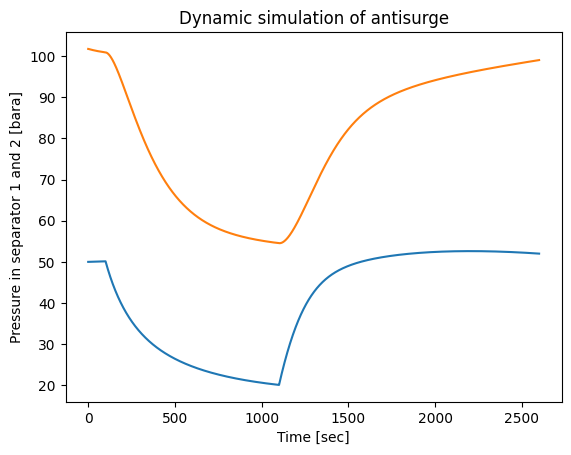

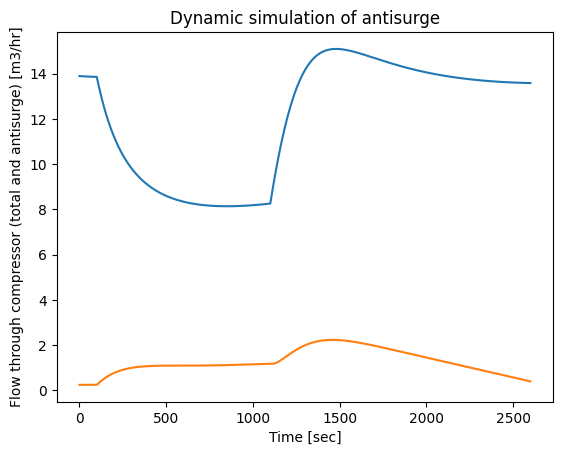

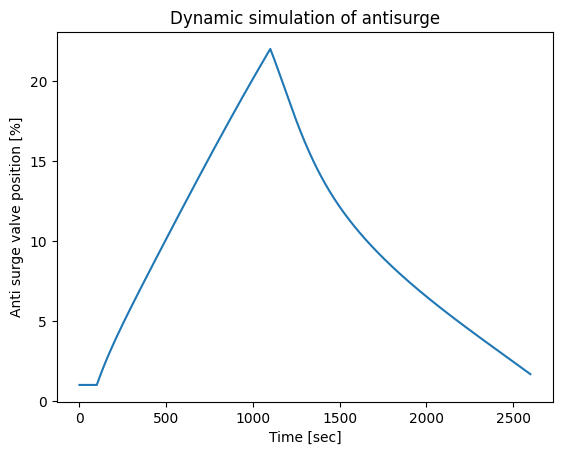

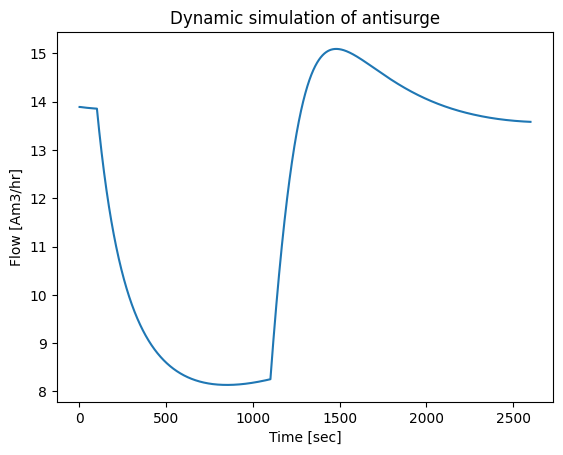

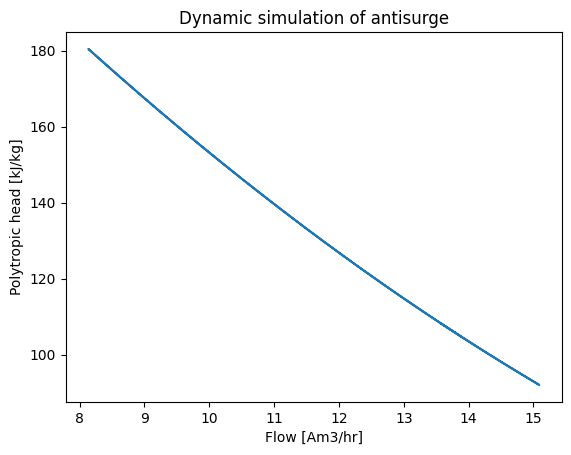

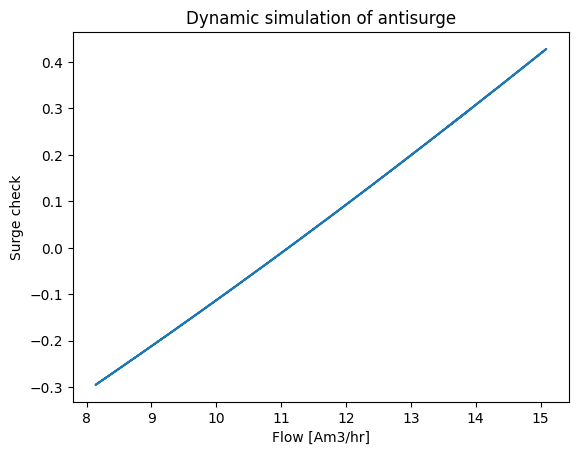

In [5]:
testSystem2 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
testSystem2.addComponent("methane", 1.1);
testSystem2.addComponent("ethane", 0.1);
testSystem2.setMixingRule(2);

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", testSystem2);
stream1.setFlowRate(500.0, "kg/hr");
stream1.setPressure(100.0, "bara");
stream1.setTemperature(55.0, "C");

valve1 =  jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(50.0);
valve1.setPercentValveOpening(50);
valve1.setCalculateSteadyState(False);

resycstream = stream1.clone()
resycstream.setName('recs')
resycstream.setFlowRate(0.01, "kg/hr");

separator1 = jneqsim.process.equipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream());
separator1.addStream(resycstream);
separator1.setCalculateSteadyState(False);
separator1.setSeparatorLength(3.0);
separator1.setInternalDiameter(0.8);
separator1.setLiquidLevel(0.0);

compressor1 = jneqsim.process.equipment.compressor.Compressor('compressor 1', separator1.getGasOutStream());
compressor1.setCalculateSteadyState(False);
compressor1.setOutletPressure(100.0);

surgemonitor = jneqsim.process.measurementdevice.CompressorMonitor(compressor1);
surgemonitor.setMaximumValue(5.0);
surgemonitor.setMinimumValue(-5.0);

aftercooler =  jneqsim.process.equipment.heatexchanger.Cooler("after cooler", compressor1.getOutletStream());
aftercooler.setOutTemperature(30.0, "C");
aftercooler.setCalculateSteadyState(False);

separator2 = jneqsim.process.equipment.separator.Separator("separator_2");
separator2.addStream(aftercooler.getOutletStream());
separator2.setCalculateSteadyState(False);
separator2.setSeparatorLength(3.0);
separator2.setInternalDiameter(0.5);
separator2.setLiquidLevel(0.0);

gasfromsep2 = jneqsim.process.equipment.stream.Stream("gas from sep", separator2.getGasOutStream());

splitter =  jneqsim.process.equipment.splitter.Splitter("splitter1", gasfromsep2);
splitter.setSplitFactors([0.99, 0.01]);
splitter.setCalculateSteadyState(False);

recycleValve = jneqsim.process.equipment.valve.ThrottlingValve("anti surge valve", splitter.getSplitStream(1));
recycleValve.setPressure(50.0);
recycleValve.setCalculateSteadyState(False);
recycleValve.setMinimumValveOpening(1.0);
recycleValve.setPercentValveOpening(2);

pressureset = jneqsim.process.equipment.util.SetPoint("HP pump set", recycleValve, "pressure", separator1.getGasOutStream());

recycle =  jneqsim.process.equipment.util.Recycle("resycle 1");
recycle.addStream(recycleValve.getOutletStream());
recycle.setOutletStream(resycstream);
recycle.setTolerance(1e-4);

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", splitter.getSplitStream(0));
valve2.setOutletPressure(50.0);
valve2.setPercentValveOpening(50);
valve2.setCalculateSteadyState(False);
valve2.setMinimumValveOpening(1.0);

surgeController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass();
surgeController.setReverseActing(True);
surgeController.setTransmitter(surgemonitor);
surgeController.setControllerSetPoint(0.1);
surgeController.setControllerParameters(1.0, 200.0, 0.0);
surgeController.setActive(True);

p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1);
p.add(resycstream);
p.add(valve1);
p.add(separator1);
p.add(compressor1);
p.add(surgemonitor);
p.add(aftercooler);
p.add(separator2);
p.add(gasfromsep2);
p.add(splitter);
p.add(recycleValve);
p.add(recycle);
p.add(valve2);
recycleValve.setController(surgeController);

#Setting compressor curves
p.run();
recycleValve.setCv(valve2.getCv());
compchartgenerator = jneqsim.process.equipment.compressor.CompressorChartGenerator(compressor1);
compressor1.setCompressorChart(compchartgenerator.generateCompressorChart("normal"));
compressor1.getCompressorChart().setUseCompressorChart(True);
p.run();

print(" speed " , compressor1.getSpeed() , "feed flow "
, stream1.getFlowRate("kg/hr") , " compressor flow rate "
, compressor1.getInletStream().getFlowRate("kg/hr") , " out flow "
, valve2.getOutletStream().getFlowRate("kg/hr") , " delta p "
, (compressor1.getOutletStream().getPressure() - compressor1.getInletStream().getPressure())
, " pres inn " , compressor1.getInletStream().getPressure() , " pres out "
, compressor1.getOutletStream().getPressure() , " distancetosurge "
, surgemonitor.getMeasuredValue("distance to surge") , " antisurgeflow "
, recycleValve.getOutletStream().getFlowRate("kg/hr") , " antisurgevalveopening "
, recycleValve.getPercentValveOpening() , " compressorouttemperature "
, compressor1.getOutStream().getTemperature("C"));

p.setTimeStep(1.0);

time = []
pressuresep1 = []
pressuresep2= []
flow = []
antisrugevalveposition = []
antisrugeflow = []
head = []
distancetosurge = []

p.runTransient();
for i in range(100):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    p.runTransient();

#setting inlet valve to 5% opening
valve1.setPercentValveOpening(5.0);

for i in range(1000):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    p.runTransient();

valve1.setPercentValveOpening(50.0);

for i in range(1500):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(time, flow)
plt.plot(time, antisrugeflow)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Flow through compressor (total and antisurge) [m3/hr]")
plt.show()

plt.plot(time, antisrugevalveposition)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Anti surge valve position [%]")
plt.show()

plt.plot(time, flow)
plt.title("Dynamic simulation of antisurge")
plt.ylabel("Flow [Am3/hr]")
plt.xlabel("Time [sec]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()

plt.plot(flow, distancetosurge)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Surge check")
plt.show()

Text(0, 0.5, 'Head [kJ/kg]')

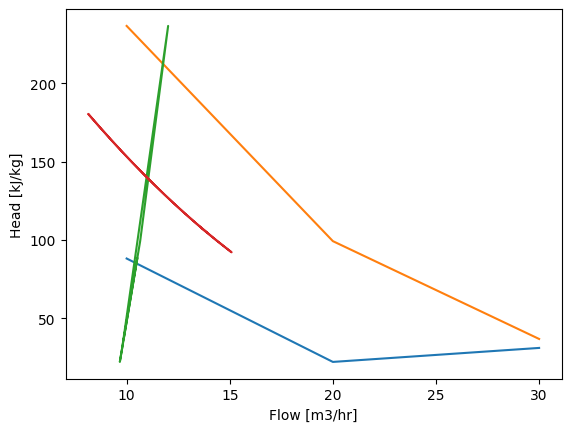

In [6]:
import numpy as np
flow1 = []
head1 = []
head2 = []
surge =[]

for i in range(10,40,10):
    flow1.append(i)
    head1.append(compressor1.getCompressorChart().getPolytropicHead(i, 2500))
    head2.append(compressor1.getCompressorChart().getPolytropicHead(i, 3500))

flowsurgee = np.array((head1+head2)).sort()#.tolist()
for i in (head1+head2):
  surge.append(compressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(i))

plt.plot(flow1, head1)
plt.plot(flow1, head2)
plt.plot(surge, (head1+head2))
plt.plot(flow, head)
plt.xlabel('Flow [m3/hr]')
plt.ylabel('Head [kJ/kg]')

#Example 4. Combining both pressure and anti surge controll of compressor
In the following example we will combine pressure controll with anti surge controll to see how the neqsim algorithm will handel such situations. Again we will reduce the feed flow to force anti surge operation. The compressor speed will be increased to compensate for reduced gas flow.

 speed  3000.0 feed flow  499.99999999999994  compressor flow rate  505.0505050001  out flow  499.99999500989986  delta p  51.74514822462504  pres inn  50.0  pres out  101.74514822462504  distancetosurge  0.29094954855580757  antisurgeflow  5.05050500009998  antisurgevalveopening  2.0  compressorouttemperature  92.12398283799928


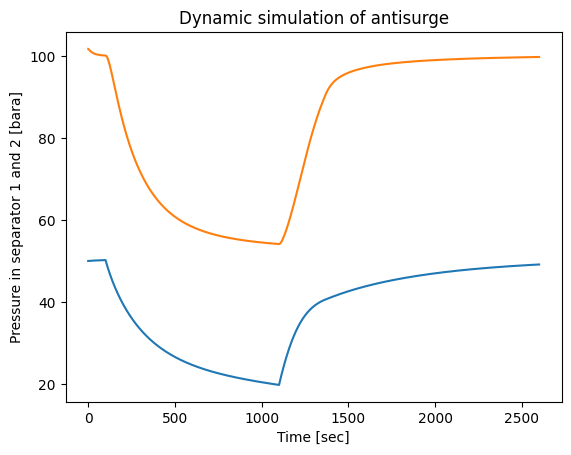

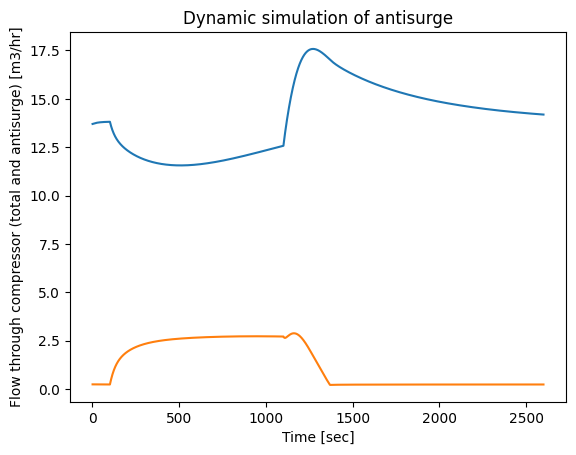

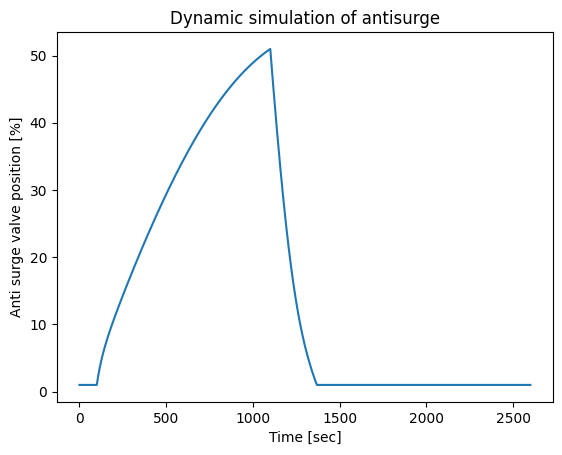

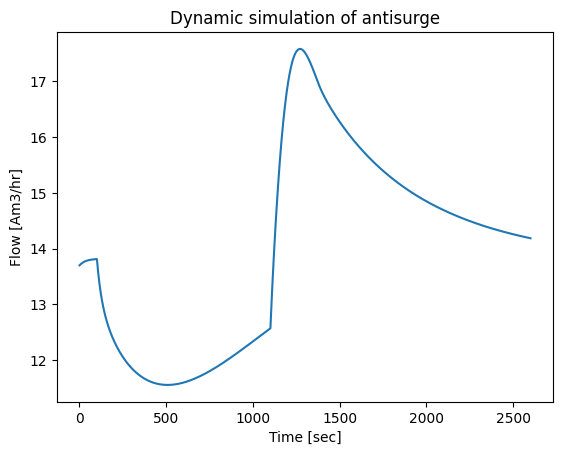

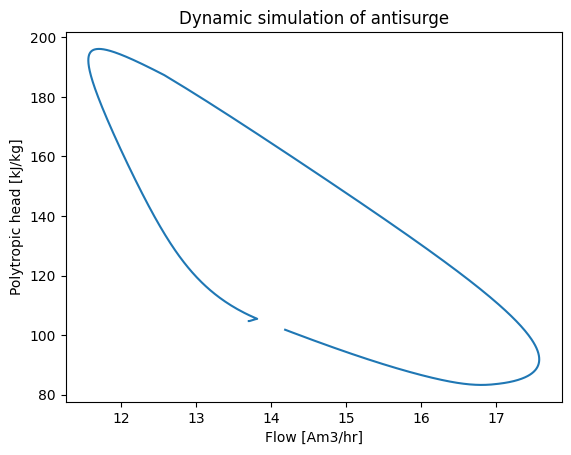

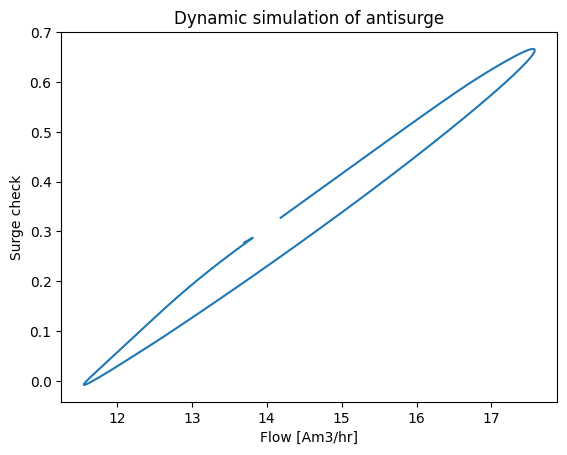

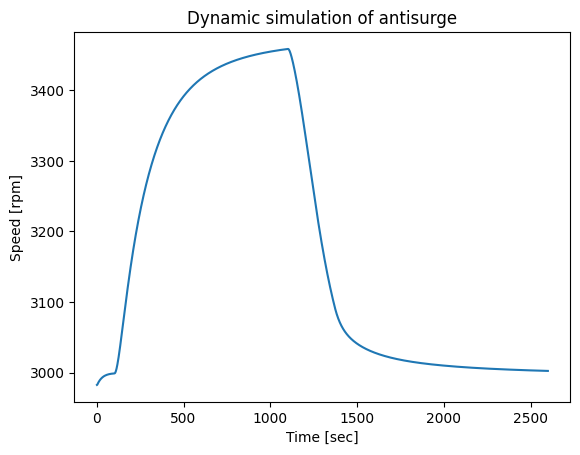

In [7]:
testSystem2 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
testSystem2.addComponent("methane", 1.1);
testSystem2.addComponent("ethane", 0.1);
testSystem2.setMixingRule(2);

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", testSystem2);
stream1.setFlowRate(500.0, "kg/hr");
stream1.setPressure(100.0, "bara");
stream1.setTemperature(55.0, "C");

valve1 =  jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(50.0);
valve1.setPercentValveOpening(50);
valve1.setCalculateSteadyState(False);

resycstream = stream1.clone();
resycstream.setName('rec1')
resycstream.setFlowRate(0.01, "kg/hr");

separator1 = jneqsim.process.equipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream());
separator1.addStream(resycstream);
separator1.setCalculateSteadyState(False);
separator1.setSeparatorLength(3.0);
separator1.setInternalDiameter(0.8);
separator1.setLiquidLevel(0.0);

compressor1 = jneqsim.process.equipment.compressor.Compressor('comp1', separator1.getGasOutStream());
compressor1.setCalculateSteadyState(False);
compressor1.setOutletPressure(100.0);

surgemonitor = jneqsim.process.measurementdevice.CompressorMonitor(compressor1);
surgemonitor.setMaximumValue(5.0);
surgemonitor.setMinimumValue(-5.0);

aftercooler =  jneqsim.process.equipment.heatexchanger.Cooler("after cooler", compressor1.getOutletStream());
aftercooler.setOutTemperature(30.0, "C");
aftercooler.setCalculateSteadyState(False);

separator2 = jneqsim.process.equipment.separator.Separator("separator_2");
separator2.addStream(aftercooler.getOutletStream());
separator2.setCalculateSteadyState(False);
separator2.setSeparatorLength(1.0);
separator2.setInternalDiameter(0.5);
separator2.setLiquidLevel(0.0);

gasfromsep2 = jneqsim.process.equipment.stream.Stream("gas from sep", separator2.getGasOutStream());

splitter =  jneqsim.process.equipment.splitter.Splitter("splitter1", gasfromsep2);
splitter.setSplitFactors([0.99, 0.01]);
splitter.setCalculateSteadyState(False);

recycleValve = jneqsim.process.equipment.valve.ThrottlingValve("anti surge valve", splitter.getSplitStream(1));
recycleValve.setPressure(50.0);
recycleValve.setCalculateSteadyState(False);
recycleValve.setMinimumValveOpening(1.0);
recycleValve.setPercentValveOpening(2);

pressureset = jneqsim.process.equipment.util.SetPoint("HP pump set", recycleValve, "pressure", separator1.getGasOutStream());

recycle =  jneqsim.process.equipment.util.Recycle("resycle 1");
recycle.addStream(recycleValve.getOutletStream());
recycle.setOutletStream(resycstream);
recycle.setTolerance(1e-4);

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", splitter.getSplitStream(0));
valve2.setOutletPressure(50.0);
valve2.setPercentValveOpening(50);
valve2.setCalculateSteadyState(False);
valve2.setMinimumValveOpening(1.0);

separatorPressureTransmitter = jneqsim.process.measurementdevice.PressureTransmitter(separator2.getGasOutStream());

speedController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass();
speedController.setReverseActing(True);
speedController.setTransmitter(separatorPressureTransmitter);
speedController.setControllerSetPoint(100.0);
speedController.setControllerParameters(0.1, 0.0, 0.0);
speedController.setActive(True);

surgeController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass();
surgeController.setReverseActing(True);
surgeController.setTransmitter(surgemonitor);
surgeController.setControllerSetPoint(0.2);
surgeController.setControllerParameters(5.0, 200.0, 0.0);
surgeController.setActive(True);

p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1);
p.add(resycstream);
p.add(valve1);
p.add(separator1);
p.add(compressor1);
p.add(surgemonitor);
p.add(aftercooler);
p.add(separator2);
p.add(gasfromsep2);
p.add(splitter);
p.add(recycleValve);
p.add(recycle);
p.add(valve2);
recycleValve.setController(surgeController);
p.add(separatorPressureTransmitter);
compressor1.setController(speedController);

#Setting compressor curves
p.run();
recycleValve.setCv(valve2.getCv());
compchartgenerator = jneqsim.process.equipment.compressor.CompressorChartGenerator(compressor1);
compressor1.setCompressorChart(compchartgenerator.generateCompressorChart("normal"));
compressor1.getCompressorChart().setUseCompressorChart(True);
p.run();

print(" speed " , compressor1.getSpeed() , "feed flow "
, stream1.getFlowRate("kg/hr") , " compressor flow rate "
, compressor1.getInletStream().getFlowRate("kg/hr") , " out flow "
, valve2.getOutletStream().getFlowRate("kg/hr") , " delta p "
, (compressor1.getOutletStream().getPressure() - compressor1.getInletStream().getPressure())
, " pres inn " , compressor1.getInletStream().getPressure() , " pres out "
, compressor1.getOutletStream().getPressure() , " distancetosurge "
, surgemonitor.getMeasuredValue("distance to surge") , " antisurgeflow "
, recycleValve.getOutletStream().getFlowRate("kg/hr") , " antisurgevalveopening "
, recycleValve.getPercentValveOpening() , " compressorouttemperature "
, compressor1.getOutStream().getTemperature("C"));

p.setTimeStep(1.0);

time = []
pressuresep1 = []
pressuresep2= []
flow = []
antisrugevalveposition = []
antisrugeflow = []
head = []
distancetosurge = []
speed = []

p.runTransient();
for i in range(100):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    speed.append(compressor1.getSpeed())
    p.runTransient();

#setting inlet valve to 5% opening
valve1.setPercentValveOpening(5.0);

for i in range(1000):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    speed.append(compressor1.getSpeed())
    p.runTransient();

valve1.setPercentValveOpening(50.0);

for i in range(1500):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    speed.append(compressor1.getSpeed())
    p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(time, flow)
plt.plot(time, antisrugeflow)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Flow through compressor (total and antisurge) [m3/hr]")
plt.show()

plt.plot(time, antisrugevalveposition)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Anti surge valve position [%]")
plt.show()

plt.plot(time, flow)
plt.title("Dynamic simulation of antisurge")
plt.ylabel("Flow [Am3/hr]")
plt.xlabel("Time [sec]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()

plt.plot(flow, distancetosurge)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Surge check")
plt.show()

plt.plot(time, speed)
plt.title("Dynamic simulation of antisurge")
plt.ylabel("Speed [rpm]")
plt.xlabel("Time [sec]")
plt.show()

Text(0, 0.5, 'Head [kJ/kg]')

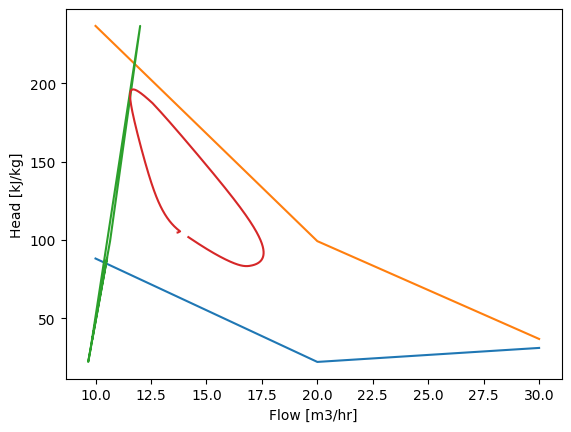

In [8]:
import numpy as np
flow1 = []
head1 = []
head2 = []
surge =[]

for i in range(10,40,10):
    flow1.append(i)
    head1.append(compressor1.getCompressorChart().getPolytropicHead(i, 2500))
    head2.append(compressor1.getCompressorChart().getPolytropicHead(i, 3500))

flowsurgee = np.array((head1+head2)).sort()#.tolist()
for i in (head1+head2):
  surge.append(compressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(i))

plt.plot(flow1, head1)
plt.plot(flow1, head2)
plt.plot(surge, (head1+head2))
plt.plot(flow, head)
plt.xlabel('Flow [m3/hr]')
plt.ylabel('Head [kJ/kg]')

#Example 5. Compressor depressurization and startup
In the following example we will continue from last simulation, and depressurize the sysyem, and then start up again.

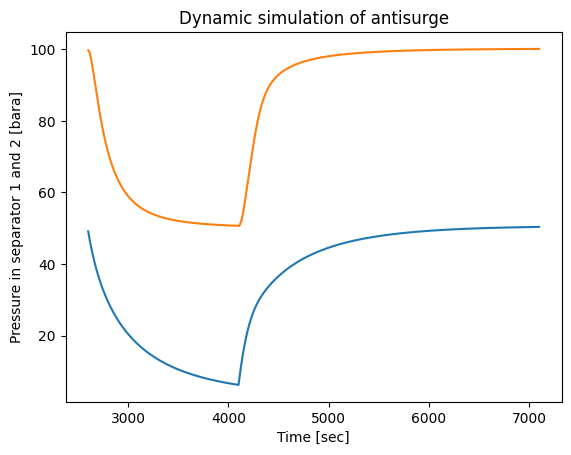

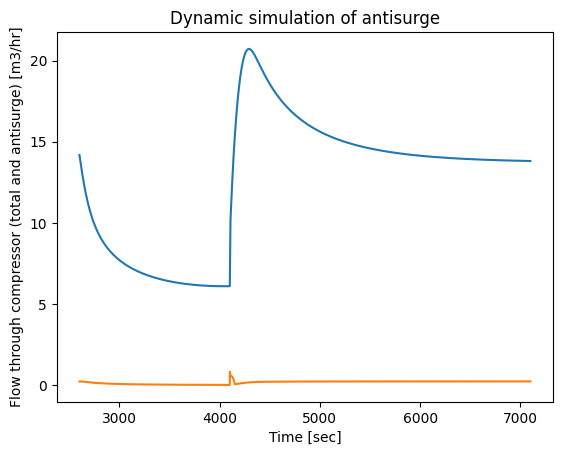

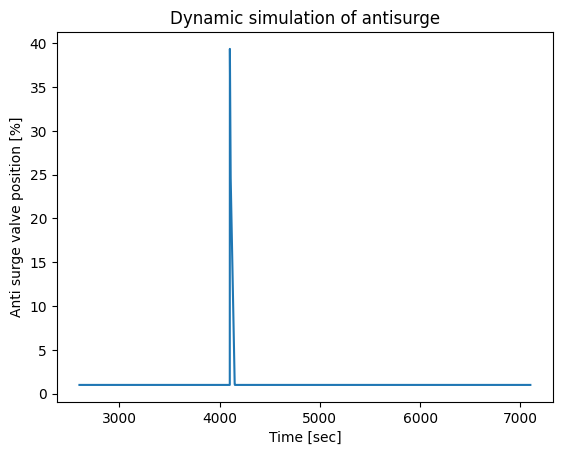

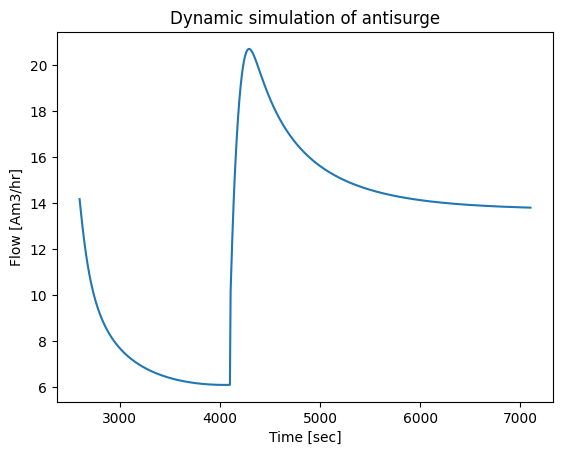

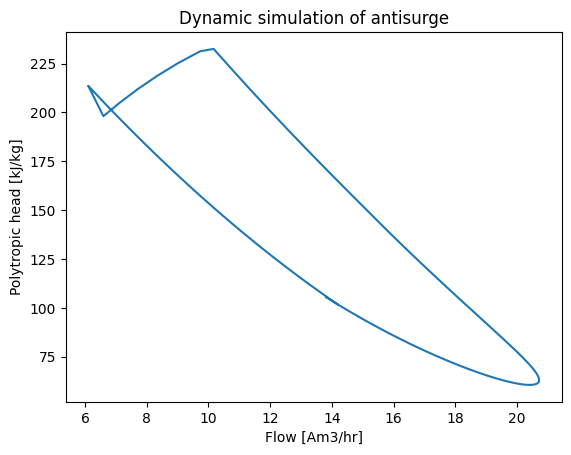

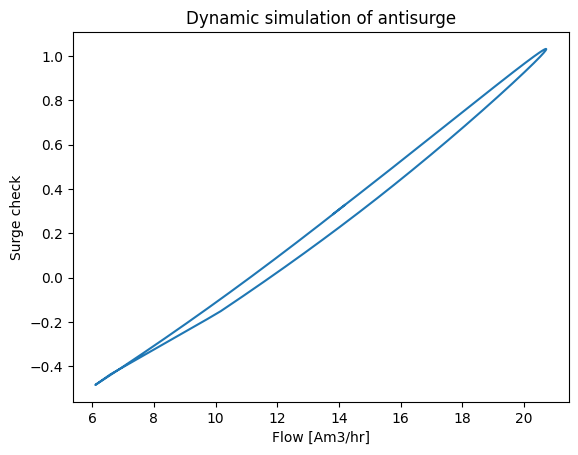

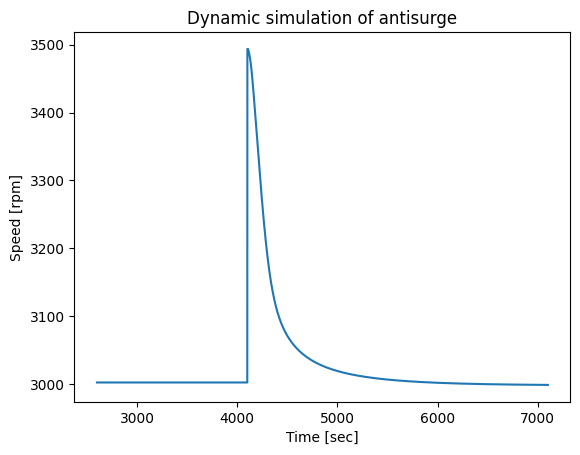

In [9]:

time = []
pressuresep1 = []
pressuresep2= []
flow = []
antisrugevalveposition = []
antisrugeflow = []
head = []
distancetosurge = []
speed = []

#First we depressurize the system by closing inlet valve and keep outlet valve
valve1.setPercentValveOpening(1.0);
valve2.setPercentValveOpening(50.0);
recycleValve.setPercentValveOpening(1.0);
speedController.setActive(False);
surgeController.setActive(False);
for i in range(1500):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    speed.append(compressor1.getSpeed())
    p.runTransient();

#Restarting the compressor and introducing more gas
valve2.setOutletPressure(50.0);
valve1.setPercentValveOpening(50.0);
speedController.setActive(True);
surgeController.setActive(True);

for i in range(3000):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    speed.append(compressor1.getSpeed())
    p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(time, flow)
plt.plot(time, antisrugeflow)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Flow through compressor (total and antisurge) [m3/hr]")
plt.show()

plt.plot(time, antisrugevalveposition)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Anti surge valve position [%]")
plt.show()

plt.plot(time, flow)
plt.title("Dynamic simulation of antisurge")
plt.ylabel("Flow [Am3/hr]")
plt.xlabel("Time [sec]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()

plt.plot(flow, distancetosurge)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Surge check")
plt.show()

plt.plot(time, speed)
plt.title("Dynamic simulation of antisurge")
plt.ylabel("Speed [rpm]")
plt.xlabel("Time [sec]")
plt.show()

Text(0, 0.5, 'Head [kJ/kg]')

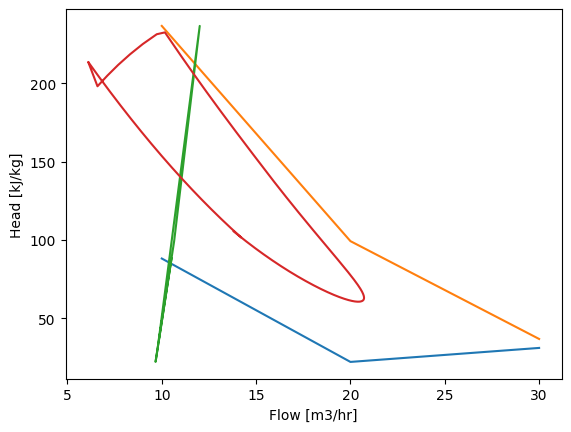

In [10]:
import numpy as np
flow1 = []
head1 = []
head2 = []
surge =[]

for i in range(10,40,10):
    flow1.append(i)
    head1.append(compressor1.getCompressorChart().getPolytropicHead(i, 2500))
    head2.append(compressor1.getCompressorChart().getPolytropicHead(i, 3500))

flowsurgee = np.array((head1+head2)).sort()#.tolist()
for i in (head1+head2):
  surge.append(compressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(i))

plt.plot(flow1, head1)
plt.plot(flow1, head2)
plt.plot(surge, (head1+head2))
plt.plot(flow, head)
plt.xlabel('Flow [m3/hr]')
plt.ylabel('Head [kJ/kg]')